图像的角点检测
检测图像中的角点（几条边相交的位置)
1.Harris角点检测 思想：边缘是在各个方向上都具有高密度变化的区域 算法基本思想是使用一个固定窗口在图像上进行任意方向上的滑动，比较滑动前与滑动后两种情况，窗口中的像素灰度变化程度，如果存在任意方向上的滑动，都有着较大灰度变化，那么我们可以认为该窗口中存在角点。
角点的特征：
    >轮廓之间的交点；
    >对于同一场景，即使视角发生变化，通常具备稳定性质的特征；
    >该点附近区域的像素点无论在梯度方向上还是其梯度幅值上有着较大变化;
    >就是一阶导数(即灰度图的梯度)中的局部最大所对应的像素点就是角点.
harris 角点检测的步骤
    1.当窗口（小的图像片段）同时向 x 和 y 两个方向移动时，计算窗口内部的像素值变化量 d f(x,y) ;
    2.对于每个窗口，都计算其对应的一个角点激活函数 G;
    3.然后对该函数进行阈值处理，如果 G > threshold，表示该窗口对应一个角点特征.

2.Shi-Tomasi角点检测
    Harris角点检测的改进版
    Shi-Tomasi 发现，角点的稳定性其实和矩阵 M 的较小特征值有关

In [257]:
'''测试'''
import numpy as np

mm = np.array([1,2,3])
pow(mm,2)

array([1, 4, 9], dtype=int32)

Harris opencv 的对应代码
cv2.cornerHarris(src, blockSize, ksize, k[, dst[, borderType]])
   参数类型
   src - 输入灰度图像，float32类型
    blockSize - 用于角点检测的邻域大小，就是上面提到的窗口的尺寸
    ksize - 用于计算梯度图的Sobel算子的尺寸
    k - 用于计算角点响应函数的参数k，取值范围常在0.04~0.06之间

注：Sobel算子是滤波算子的形式,利用快速卷积函数， 简单有效，因此应用广泛
    优点：方法简单、处理速度快,并且所得的边缘光滑
    缺点：Sobel算子并没有将图像的主体与背景严格地区分开来，换言之就是Sobel算子没有基于图像灰度进行处理
    原理：
    sobel算子的horizon垂直检测Sob_x：
        [[-1,0,1],
        [-2,0,2],
        [-1,0,1]]
    sobel算子的vertical水平检测 Sob_y：
        [[1,2,1],
        [0,0,0],
        [-1,-2,-1]]
    矩阵公式：
            Gx = Sob_x *img.data  Gy = Sob_y * img.data
            G的运算采用L2 范数,节约时间可用L1范数
            L2：G = np.sqrt(pow(Gx,2)+pow(Gy,2)
            L1：G = |Gx|+|Gy|
            得到梯度值,若G大于阈值threshold,则说明有角点
            再由 theta = 1/tan(Gy/Gx)得到梯度的方向
            若theta 角度为0 代表图像有纵向边缘

In [258]:
'''初始化'''
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
'''Sober算子,初始化'''
sob_x ,sob_y= [[-1,0,1],[-2,0,2],[-1,0,1]], \
              [[1,2,1],[0,0,0],[-1,-2,-1]]

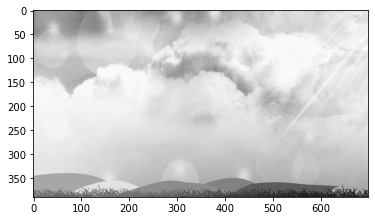

In [259]:
'''图片读取并灰度化'''
img1 = cv2.imread('figures/image1.jpeg') #读取通道为BGR
img1_gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY) #BGR通道转为Gray,
# 类型type(img1_gray)  numpy.ndarray,shape (390, 700)

plt.imshow(img1_gray,cmap='gray')
plt.show()

In [260]:
'''这里舍弃最外围的一圈像素点 实际sobel算子卷积了 388x698图片'''

# 切片操作，取第一个需要卷积的矩阵，其核心位置为【1，1】
d10 = img1_gray[0:10,0:10]
d1 = img1_gray[0:3,0:3]
d10,d1

(array([[135, 139, 143, 146, 148, 152, 156, 159, 161, 162],
        [135, 138, 142, 145, 148, 151, 155, 158, 161, 162],
        [134, 137, 142, 145, 147, 150, 154, 158, 161, 162],
        [134, 137, 141, 144, 147, 150, 154, 157, 161, 162],
        [134, 138, 142, 145, 147, 150, 155, 158, 161, 162],
        [136, 139, 143, 146, 148, 152, 156, 159, 161, 162],
        [137, 140, 144, 148, 150, 153, 157, 160, 161, 162],
        [138, 141, 145, 148, 151, 154, 158, 161, 161, 162],
        [144, 145, 146, 148, 150, 152, 154, 155, 160, 160],
        [144, 144, 145, 147, 148, 150, 152, 153, 160, 160]], dtype=uint8),
 array([[135, 139, 143],
        [135, 138, 142],
        [134, 137, 142]], dtype=uint8))

In [261]:
'''定义一个卷积函数'''
def convolution(kernal, data_gray):
    #没加padding, 最下面两行无法计算 ，故而需要减去2 ，类比于torch.nn 类中的 nn.Conv2d
    n,m = data_gray.shape #返回元组
    img_new = []
    for i in range(n-3):
        line = []
        for j in range(m-3):
            temp = data_gray[i:i+3,j:j+3]
            line.append(np.sum(np.multiply(kernal, temp)))
        img_new.append(line)
    return np.array(img_new)


# def convolution_ndarray(kernal,data_gray):
#     n,m = data_gray.shape #(390, 700)
#     img_new= np.zeros_like(data_gray)
#     for i in range(n-3): #[0,387)
#         temp_row = np.zeros(m)
#         for j in range(m-3): #[0,387)
#             temp = data_gray[i:i+3,j:j+3]
#             temp_row[j] = np.sum(np.multiply(kernal,temp))
#         img_new[i] = temp_row
#     return img_new





Gx = convolution(sob_x,img1_gray)

Gy = convolution(sob_y,img1_gray)
# L1范数
G_L1 = np.absolute(Gx) +np.absolute(Gy)
# L2范数
G_L2 = np.sqrt(pow(Gx,2)+pow(Gy,2))

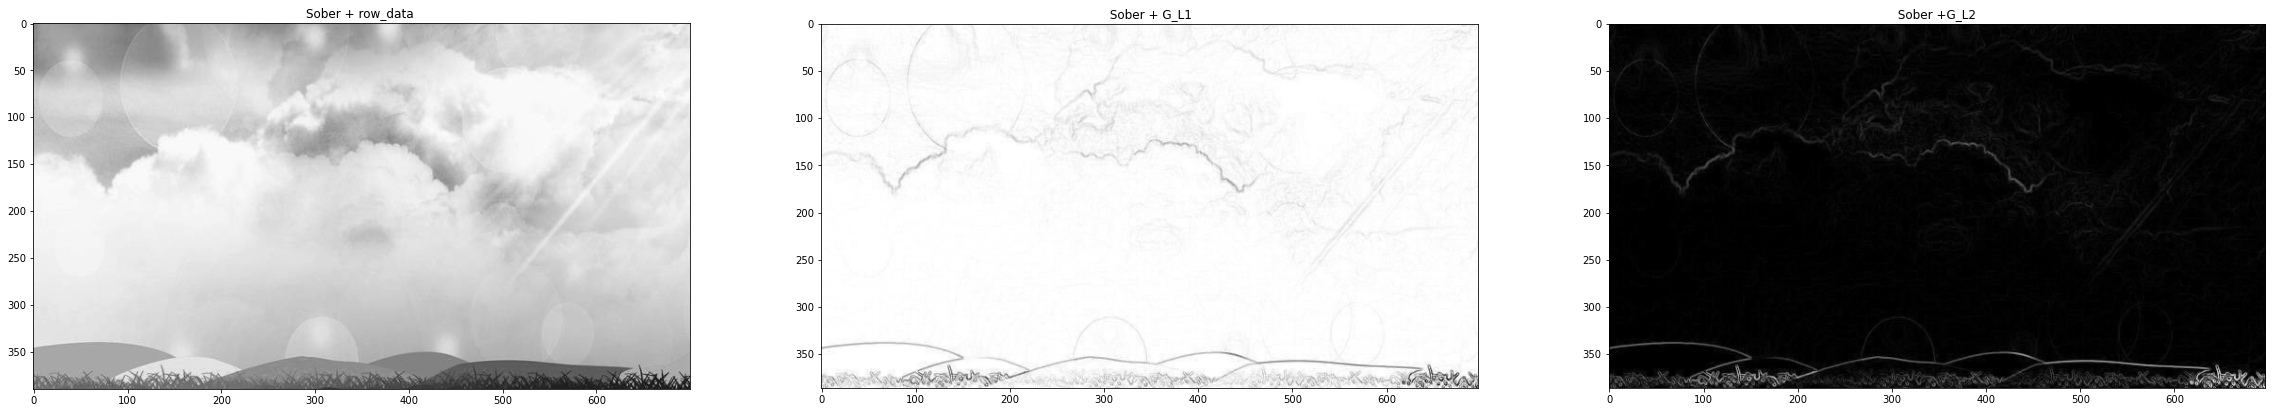

In [262]:
# 255矩阵
ones = np.ones(G_L1.shape)*255 #ones.shape (387, 697)


plt.figure(figsize=(40,40))
plt.subplot(131)
plt.imshow(img1_gray, cmap='gray')
plt.title('Sober + row_data ')

Color_Reversal_1 = ones -G_L1 #颜色反转
plt.subplot(132)
plt.imshow(Color_Reversal_1,cmap='gray')
plt.title(' Sober + G_L1')

Color_Reversal_2 = ones-G_L2    #颜色反转
plt.subplot(133)
plt.imshow(G_L2,cmap='gray')
plt.title(' Sober +G_L2 ')
plt.show()